In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import geopandas as gpd
import re
import openpyxl
import nbformat
import ipykernel
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn import metrics, preprocessing
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
from plotly.subplots import make_subplots
from sklearn.preprocessing  import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV, cross_val_score

from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Conv1D, Dense, Flatten, MaxPooling1D
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [30]:
import random 
random.seed(42)

In [31]:
df = pd.read_excel(r"C:\Users\maserati\Desktop\Master_Maserati\M2\0- Mémoire Porjet M2\Données\base_tx_chomage.xlsx", sheet_name="Feuil2")
df.head()

,Time period,France,Germany,Greece,Italy,Spain,United Kingdom
0,1991-Jan,9.2,5.2,7.57,8.7,15.1,7.5
1,1991-Feb,9.3,5.2,7.68,8.6,15.1,7.7
2,1991-Mar,9.3,5.3,7.79,8.6,15.1,8.1
3,1991-Apr,9.4,5.3,7.90,8.5,15.2,8.3
4,1991-May,9.4,5.3,8.01,8.5,15.3,8.5


In [32]:
# Étape 1 : Conversion de la colonne date
df['ds'] = pd.to_datetime(df['Time period'], format="mixed")

# Étape 2 : Transformation en format long
df_long = df.melt(id_vars=['ds'], value_vars=['France', 'Germany', 'Greece', 'Italy', 'Spain', 'United Kingdom'],
                  var_name='country', value_name='y')

df_prophet_ready = df_long.dropna()

In [33]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

# Fonction de test ADF par pays
def adf_test_by_country(df):
    results = []
    for country in df['country'].unique():
        series = df[df['country'] == country].sort_values('ds')['y']
        result = adfuller(series)
        results.append({
            'Pays': country,
            'Statistique ADF': round(result[0], 3),
            'p-value': round(result[1], 3),
            'Seuil critique 1%': result[4]['1%'],
            'Seuil critique 5%': result[4]['5%'],
            'Seuil critique 10%': result[4]['10%'],
            'Stationnaire (p < 0.05)': result[1] < 0.05
        })
    return pd.DataFrame(results)

# Application sur ton DataFrame long
adf_results = adf_test_by_country(df_prophet_ready)

# Affichage propre
print("\n📊 Résultats du test ADF par pays\n")
print(adf_results.to_string(index=False))


📊 Résultats du test ADF par pays

          Pays  Statistique ADF  p-value  Seuil critique 1%  Seuil critique 5%  Seuil critique 10%  Stationnaire (p < 0.05)
        France           -1.321    0.619          -3.446681          -2.868739           -2.570605                    False
       Germany           -1.164    0.689          -3.446560          -2.868685           -2.570576                    False
        Greece           -1.990    0.291          -3.447057          -2.868904           -2.570693                    False
         Italy           -1.595    0.486          -3.446930          -2.868848           -2.570663                    False
         Spain           -2.080    0.252          -3.446722          -2.868757           -2.570614                    False
United Kingdom           -2.157    0.222          -3.446804          -2.868793           -2.570634                    False


Fit du train

In [80]:
from prophet import Prophet

countries = df_prophet_ready['country'].unique()
prophet_models = {}

for country in countries:
    df_country = df_prophet_ready[df_prophet_ready['country'] == country][['ds', 'y']].copy()
    train = df_country[df_country['ds'] < '2024-01-01'].copy()
    test = df_country[df_country['ds'] >= '2024-01-01'].copy()

    # Refit Prophet uniquement sur le train
    model = Prophet(changepoints=['1995-01-01', '2008-01-01', '2013-01-01', '2020-03-01'],
        yearly_seasonality=True,
        changepoint_prior_scale=0.2,  # Ajuste la sensibilité aux changements
        seasonality_mode='additive',  # Utilise la saisonnalité multiplicative
        holidays=None,  # Tu peux ajouter des jours fériés si nécessaire
        interval_width=0.95,  # Intervalle de confiance à 95%
        daily_seasonality=False,  # Pas de saisonnalité quotidienne
        weekly_seasonality=False  # Pas de saisonnalité hebdomadaire
    )
    model.add_seasonality(name='quarterly', period=91.31, fourier_order=5)
    model.fit(train)
    
    # Sauvegarde du modèle
    prophet_models[country] = model

print("✅ Tous les modèles Prophet sont entraînés.")



15:15:53 - cmdstanpy - INFO - Chain [1] start processing
15:15:53 - cmdstanpy - INFO - Chain [1] done processing
15:15:53 - cmdstanpy - INFO - Chain [1] start processing
15:15:53 - cmdstanpy - INFO - Chain [1] done processing
15:15:53 - cmdstanpy - INFO - Chain [1] start processing
15:15:53 - cmdstanpy - INFO - Chain [1] done processing
15:15:54 - cmdstanpy - INFO - Chain [1] start processing
15:15:54 - cmdstanpy - INFO - Chain [1] done processing
15:15:54 - cmdstanpy - INFO - Chain [1] start processing
15:15:54 - cmdstanpy - INFO - Chain [1] done processing
15:15:54 - cmdstanpy - INFO - Chain [1] start processing
15:15:54 - cmdstanpy - INFO - Chain [1] done processing


✅ Tous les modèles Prophet sont entraînés.


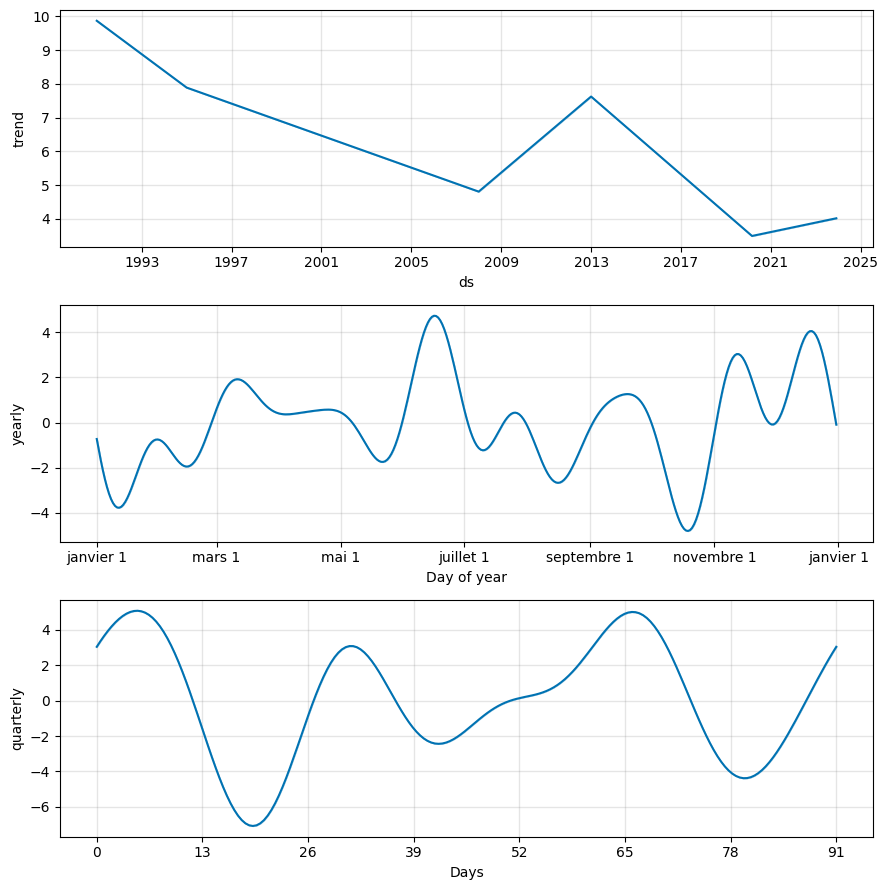

In [79]:
model.plot_components(forecast);


Visualisation

📊 Plot for: France


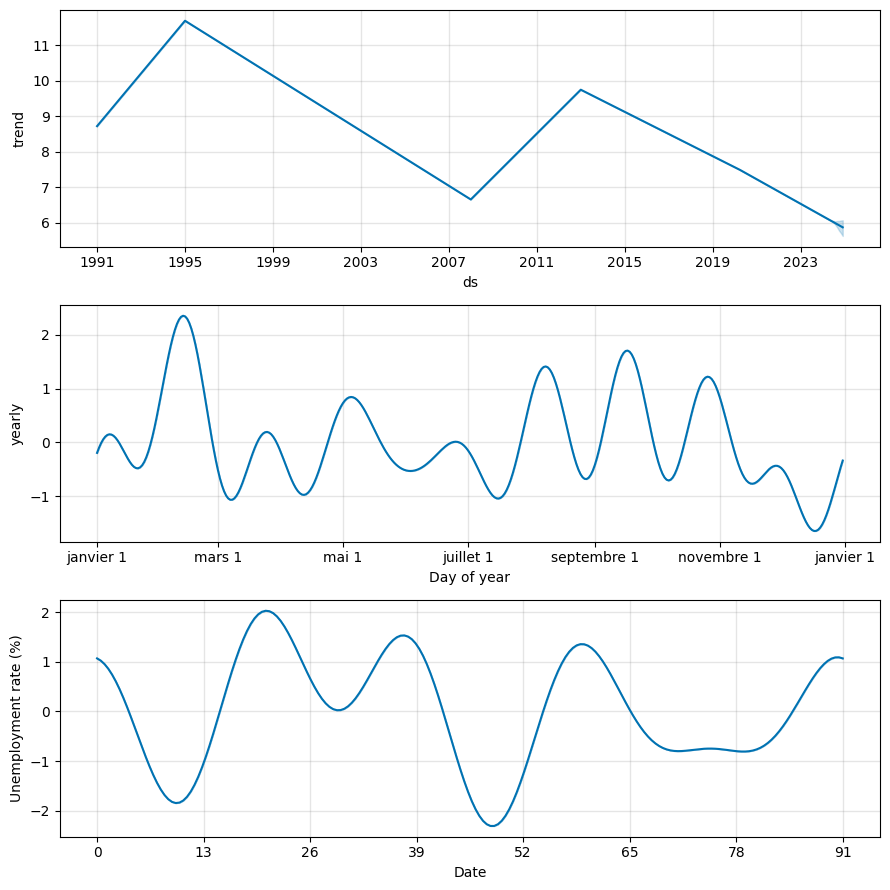

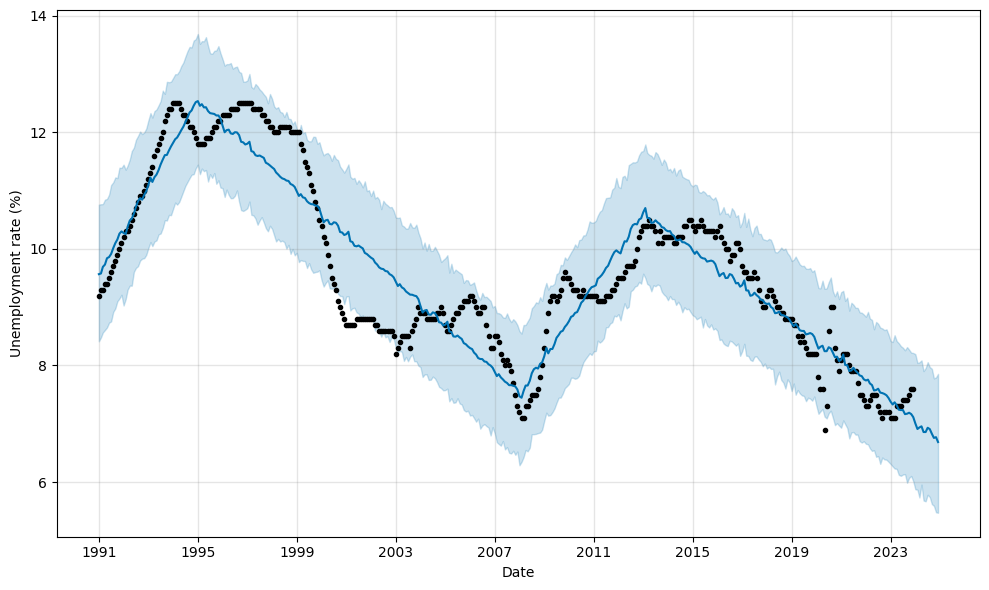

📊 Plot for: Germany


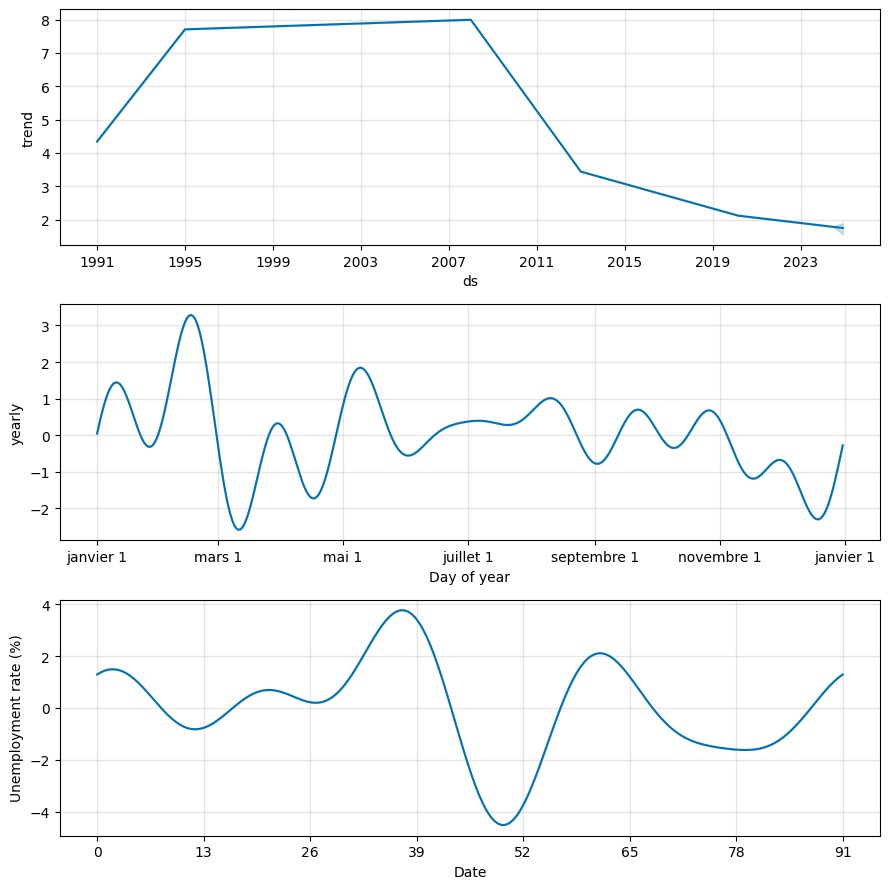

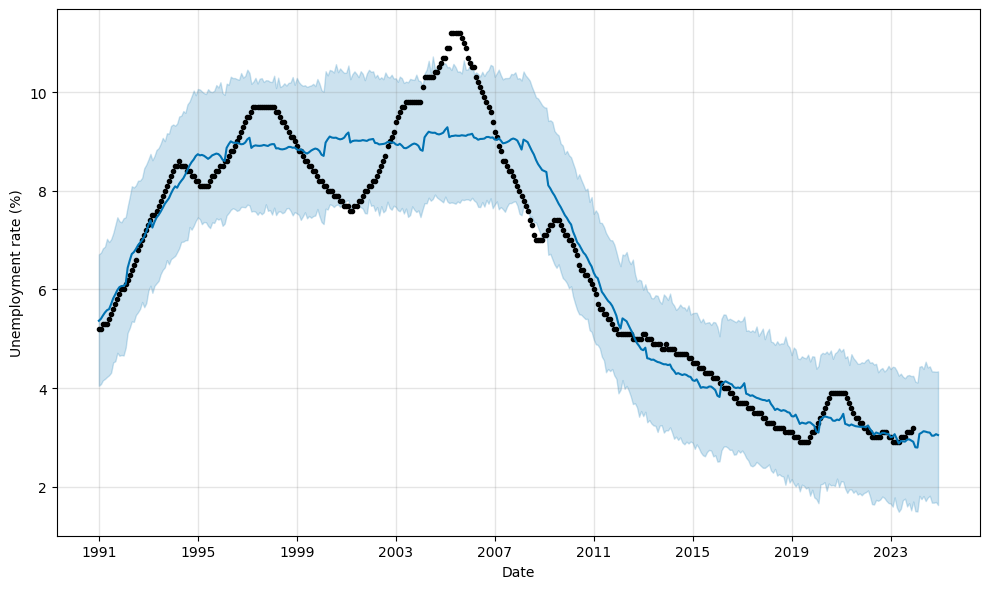

📊 Plot for: Greece


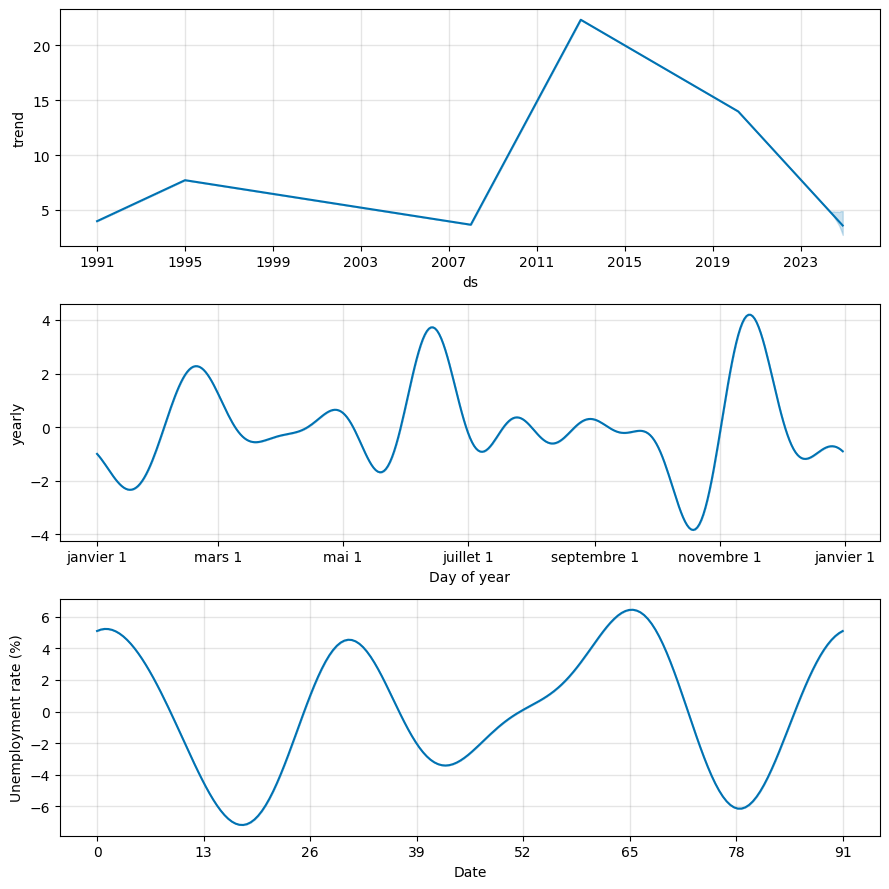

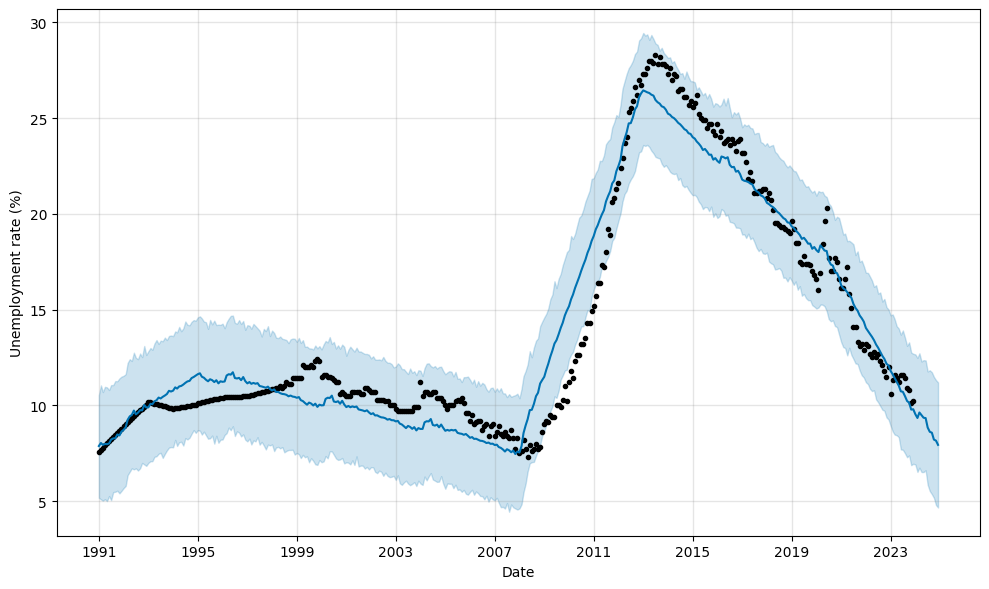

📊 Plot for: Italy


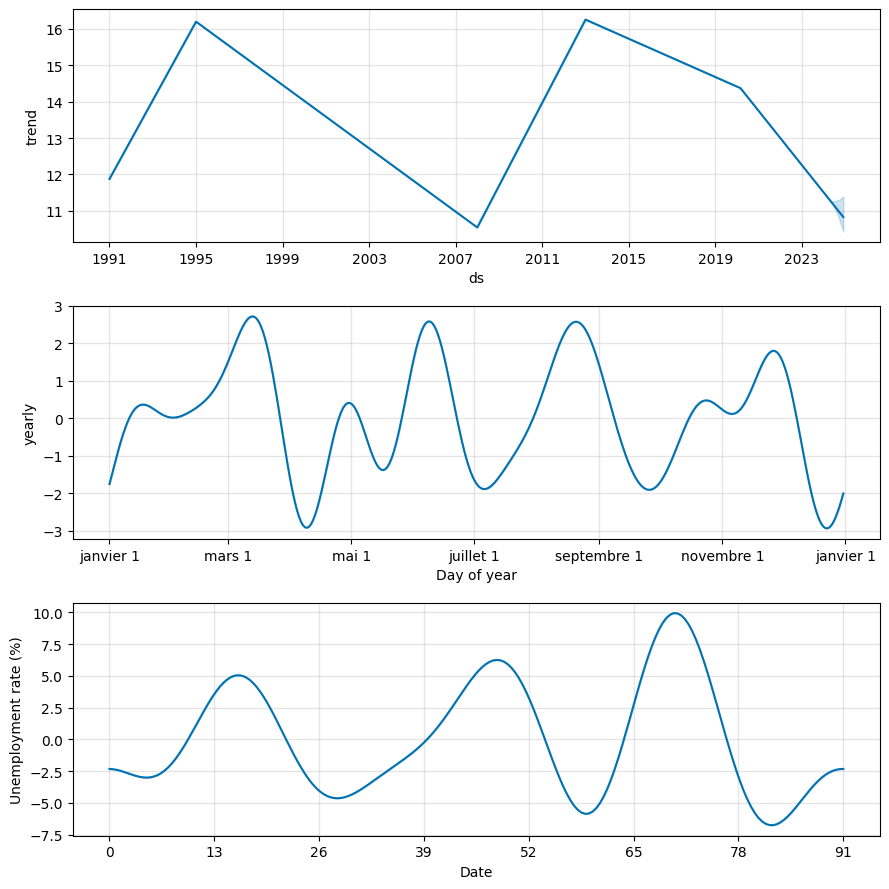

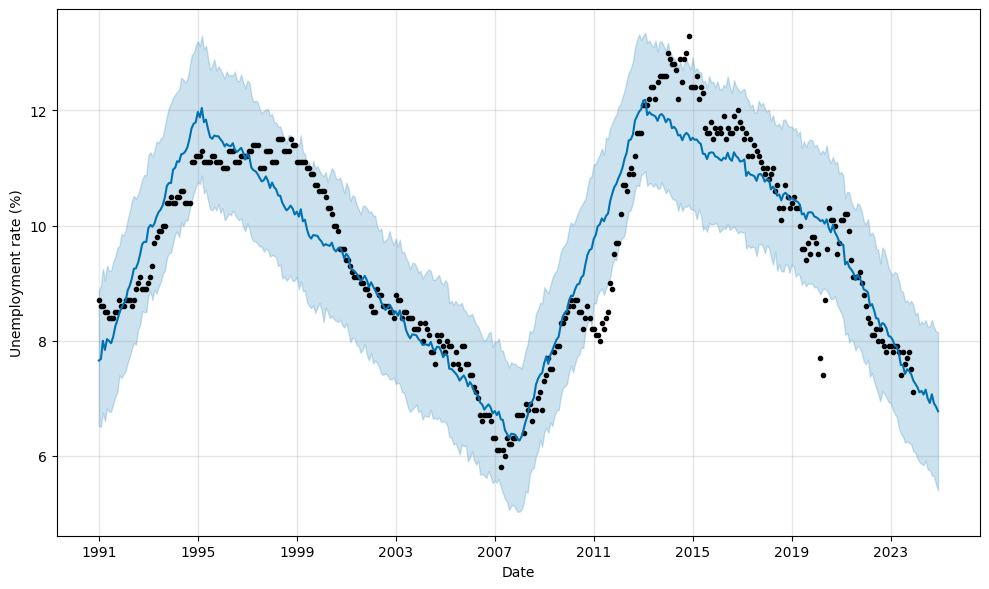

📊 Plot for: Spain


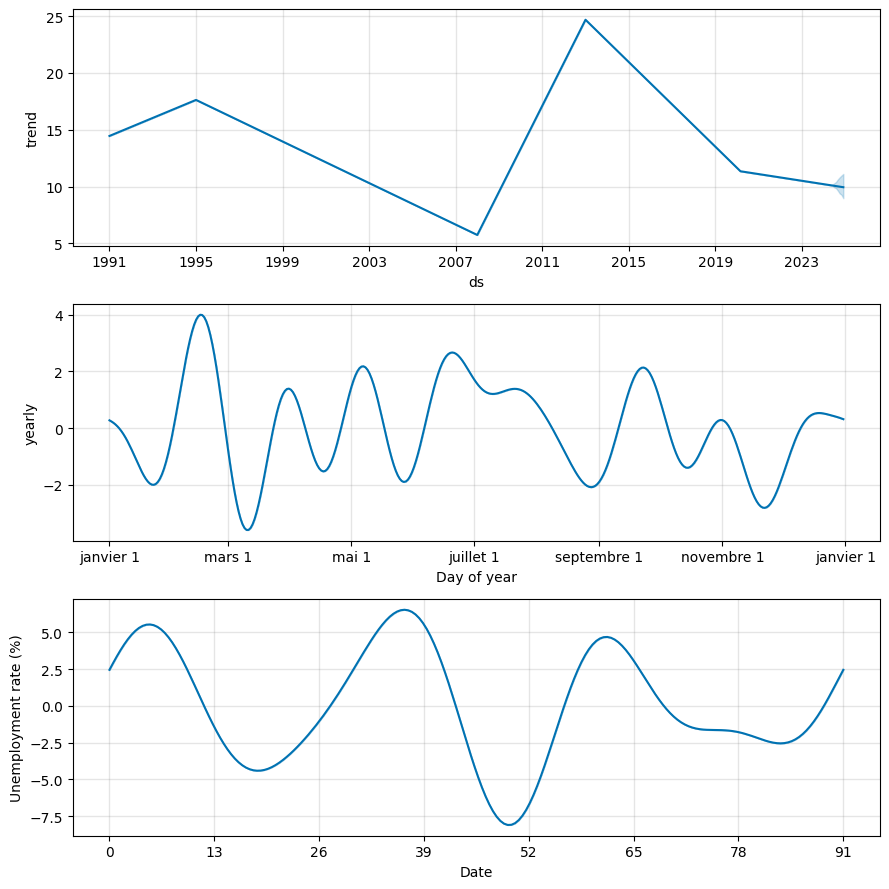

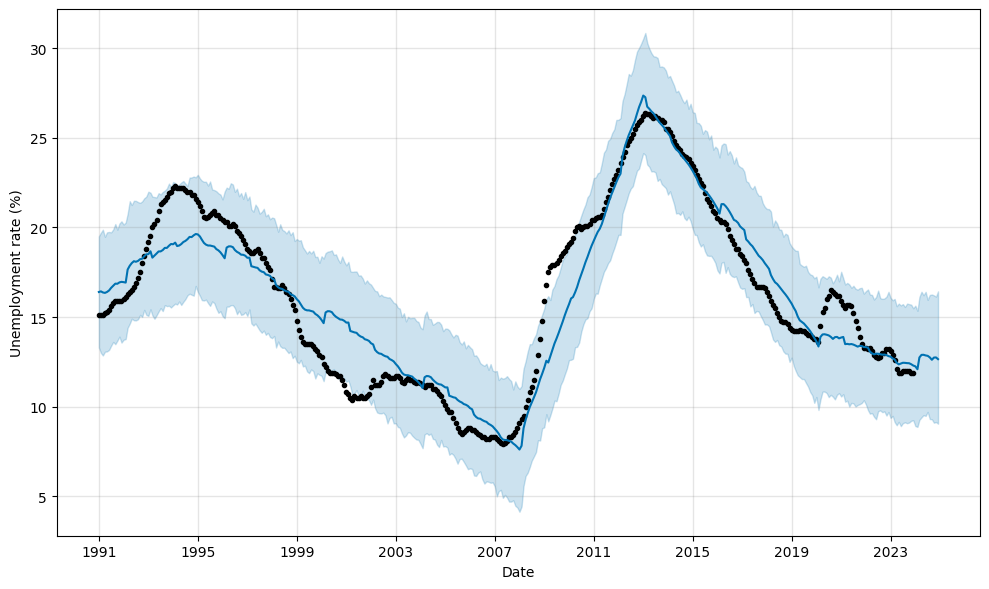

📊 Plot for: United Kingdom


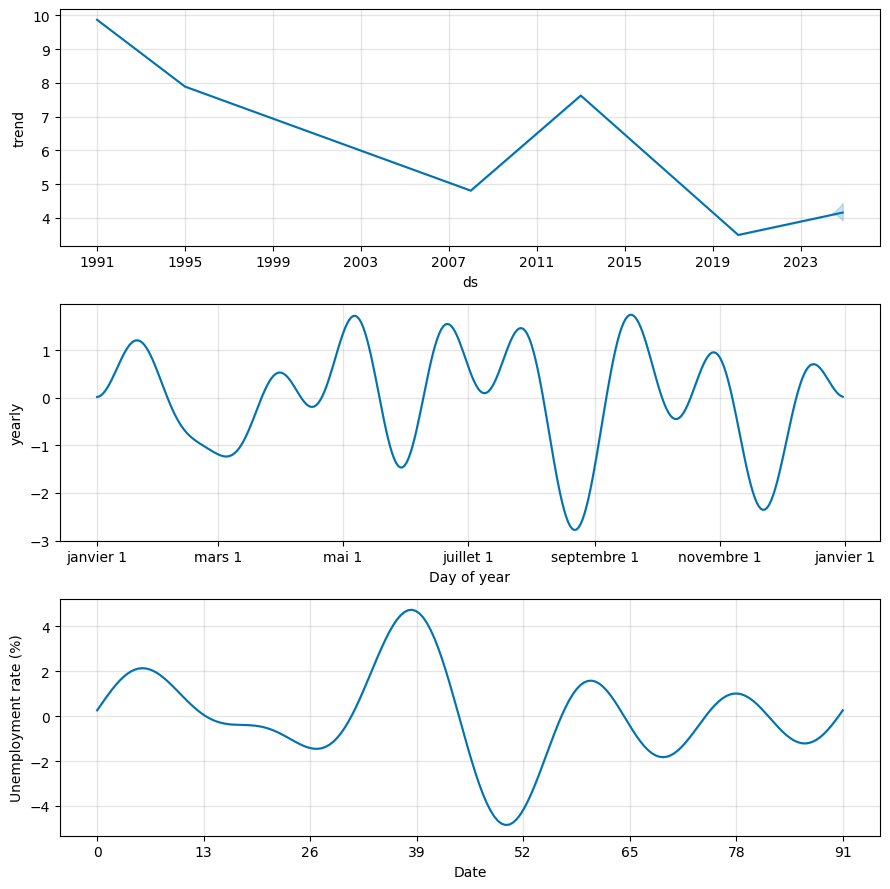

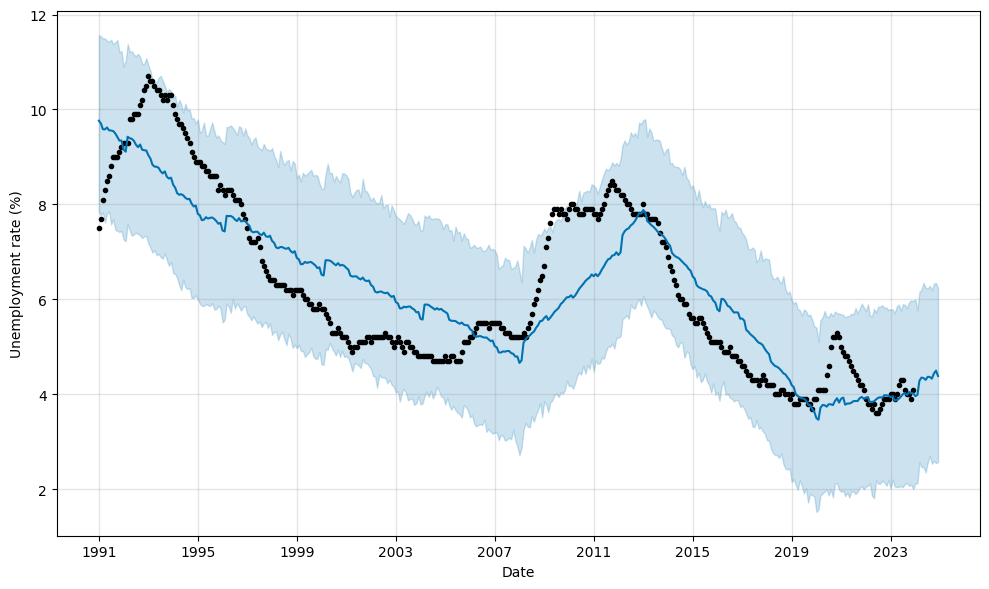

In [83]:
for country in countries:
    print(f"📊 Plot for: {country}")
    
    model = prophet_models[country]
    df_country = df_prophet_ready[df_prophet_ready['country'] == country][['ds', 'y']].copy()

    # 12 months future projection
    future = model.make_future_dataframe(periods=12, freq='MS')
    forecast = model.predict(future)

    # Plot Prophet components
    fig = model.plot_components(forecast)
    plt.xlabel("Date")
    plt.ylabel("Unemployment rate (%)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot forecast
    fig = model.plot(forecast)
    plt.xlabel("Date")
    plt.ylabel("Unemployment rate (%)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Modèle entrainement avec le train prediction sur test


📊 Résultats des erreurs de prédiction par pays
       Country  RMSE  MAE  MAPE (%)
United Kingdom  0.14 0.12      2.69
        France  0.54 0.53      7.19
         Italy  0.57 0.51      8.17
       Germany  0.41 0.40     11.53
         Spain  1.48 1.39     12.52
        Greece  1.39 1.30     13.05



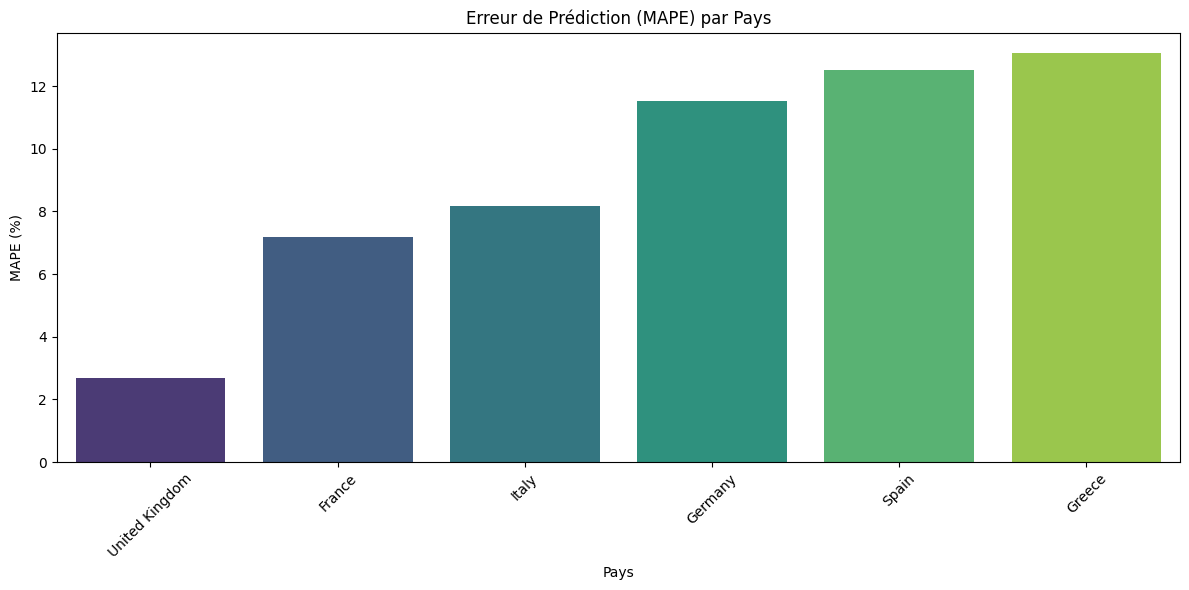

In [63]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Fonction sécurisée pour MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = pd.Series(y_true), pd.Series(y_pred)
    return (np.abs((y_true - y_pred) / y_true)).replace([np.inf, -np.inf], np.nan).dropna().mean() * 100


# Tableau pour stocker les résultats
results = []

for country in countries:
    model = prophet_models[country]
    df_country = df_prophet_ready[df_prophet_ready['country'] == country][['ds', 'y']].copy()
    train = df_country[df_country['ds'] < '2024-01-01'].copy()
    test = df_country[df_country['ds'] >= '2024-01-01'].copy()

    # # Prédiction
    # future = model.make_future_dataframe(periods=12, freq='MS')
    # forecast = model.predict(future)

    # Prédiction uniquement sur la période test
    future = test[['ds']].copy()
    forecast = model.predict(future)

    # Erreurs
    y_true = test['y'].values
    y_pred = forecast['yhat'].values

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    results.append({
        'Country': country,
        'RMSE': round(rmse, 2),
        'MAE': round(mae, 2),
        'MAPE (%)': round(mape, 2)
    })

# Résultat sous forme de DataFrame
results_df = pd.DataFrame(results).sort_values(by="MAPE (%)")

print("\n📊 Résultats des erreurs de prédiction par pays\n"
      f"{results_df.to_string(index=False)}\n")
# Visualisation des erreurs de prédiction
plt.figure(figsize=(12, 6))
sns.barplot(x='Country', y='MAPE (%)', data=results_df, palette='viridis')
plt.title('Erreur de Prédiction (MAPE) par Pays')
plt.xlabel('Pays')
plt.ylabel('MAPE (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Visu prédiction de test

13:07:02 - cmdstanpy - INFO - Chain [1] start processing
13:07:02 - cmdstanpy - INFO - Chain [1] done processing


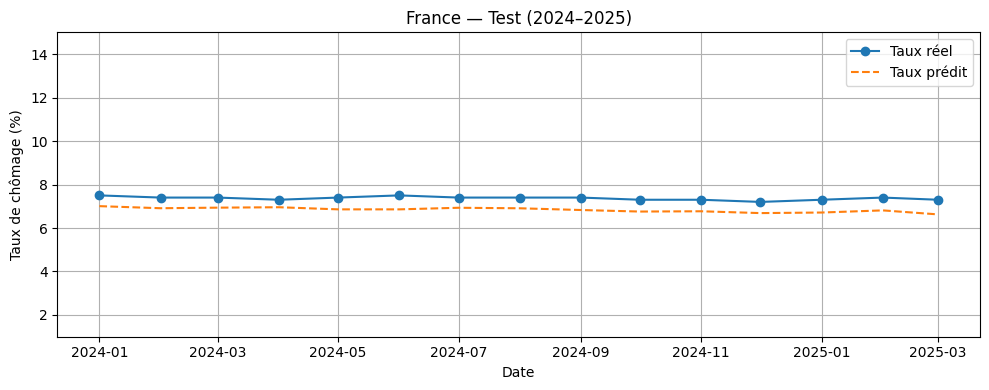

13:07:02 - cmdstanpy - INFO - Chain [1] start processing
13:07:02 - cmdstanpy - INFO - Chain [1] done processing


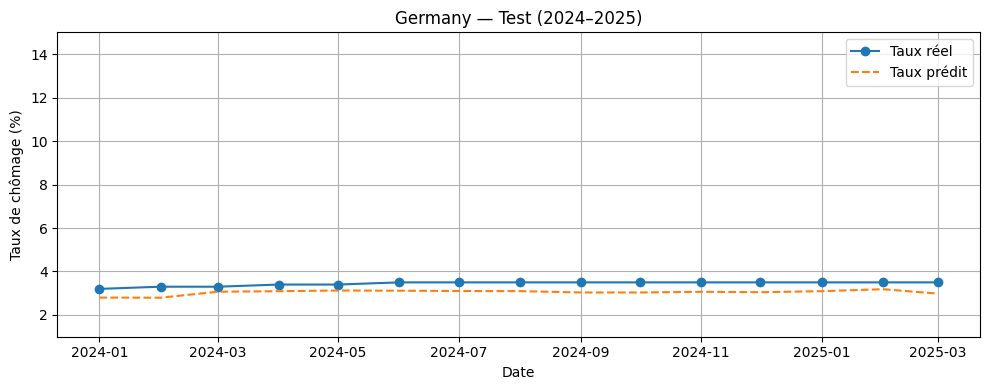

13:07:03 - cmdstanpy - INFO - Chain [1] start processing
13:07:03 - cmdstanpy - INFO - Chain [1] done processing


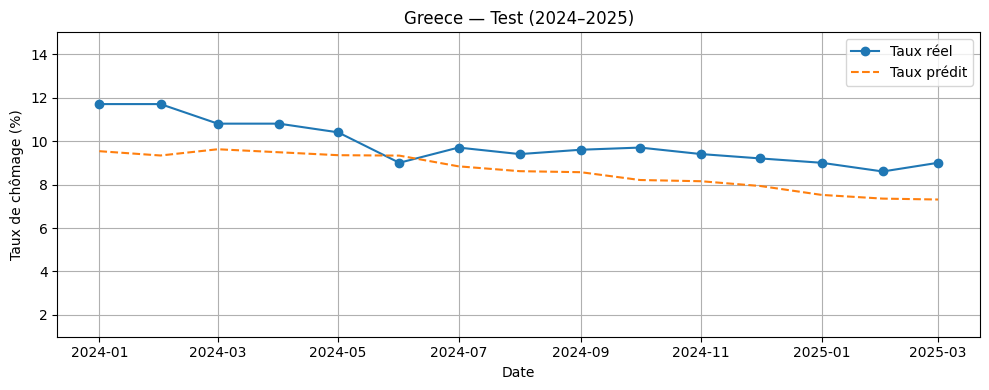

13:07:03 - cmdstanpy - INFO - Chain [1] start processing
13:07:03 - cmdstanpy - INFO - Chain [1] done processing


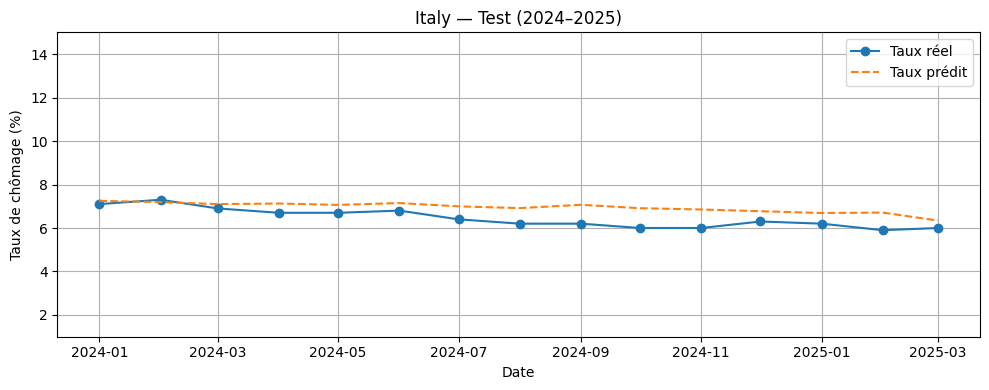

13:07:04 - cmdstanpy - INFO - Chain [1] start processing
13:07:04 - cmdstanpy - INFO - Chain [1] done processing


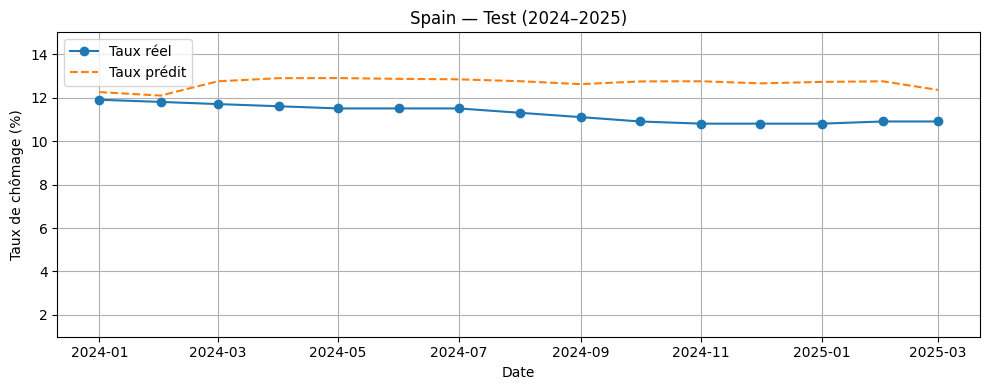

13:07:04 - cmdstanpy - INFO - Chain [1] start processing
13:07:04 - cmdstanpy - INFO - Chain [1] done processing


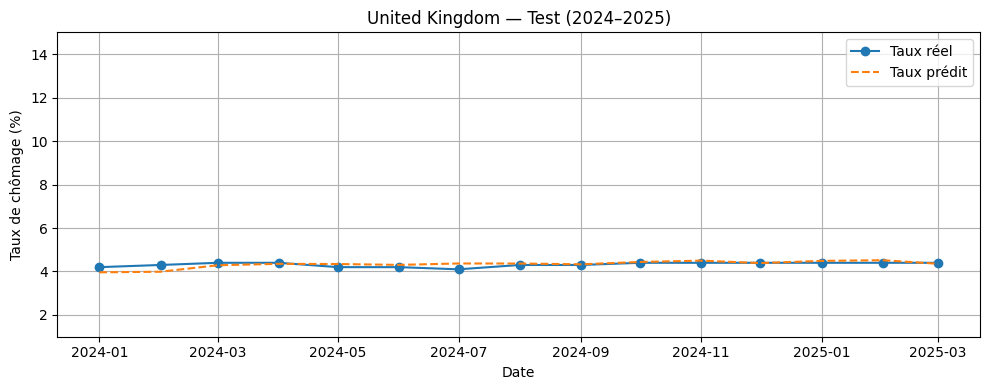

In [58]:


# Boucle de visualisation pays par pays
for country in countries:
    df_country = df_prophet_ready[df_prophet_ready['country'] == country][['ds', 'y']].copy()
    train = df_country[df_country['ds'] < '2024-01-01'].copy()
    test = df_country[df_country['ds'] >= '2024-01-01'].copy()

    # Refit Prophet uniquement sur le train
    model = Prophet(
        changepoints=['1995-01-01', '2008-01-01', '2013-01-01', '2020-03-01'],
        yearly_seasonality=True,
        changepoint_prior_scale=0.2,  # Ajuste la sensibilité aux changements
        seasonality_mode='additive',  # Utilise la saisonnalité multiplicative
        holidays=None,  # Tu peux ajouter des jours fériés si nécessaire
        interval_width=0.95,  # Intervalle de confiance à 95%
        daily_seasonality=False,  # Pas de saisonnalité quotidienne
        weekly_seasonality=False  # Pas de saisonnalité hebdomadaire
    )
    model.add_seasonality(name='quarterly', period=91.31, fourier_order=5)
    model.fit(train)

    # Prédire uniquement les dates test
    future = test[['ds']].copy()
    forecast = model.predict(future)

    # Tracer y réel vs yhat
    plt.figure(figsize=(10, 4))
    plt.plot(test['ds'], test['y'], label='Taux réel', marker='o')
    plt.plot(forecast['ds'], forecast['yhat'], label='Taux prédit', linestyle='--')
    plt.title(f"{country} — Test (2024–2025)")
    plt.xlabel("Date")
    plt.ylabel("Taux de chômage (%)")
    plt.ylim(1, 15)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [59]:
from prophet.diagnostics import cross_validation, performance_metrics


# Données France uniquement
df_france = df_prophet_ready[df_prophet_ready['country'] == 'France'][['ds', 'y']].copy()

# Entraînement du modèle Prophet
model = Prophet(changepoints=['1995-01-01', '2008-01-01', '2013-01-01', '2020-03-01'],
        yearly_seasonality=True,
        changepoint_prior_scale=0.2,  # Ajuste la sensibilité aux changements
        seasonality_mode='additive',  # Utilise la saisonnalité multiplicative
        holidays=None,  # Tu peux ajouter des jours fériés si nécessaire
        interval_width=0.95,  # Intervalle de confiance à 95%
        daily_seasonality=False,  # Pas de saisonnalité quotidienne
        weekly_seasonality=False  # Pas de saisonnalité hebdomadaire
)
model.add_seasonality(name='quarterly', period=91.31, fourier_order=5)
model.fit(df_france)

# Cross-validation : prédire 2 ans à l'avance, en avançant tous les 6 mois
df_cv = cross_validation(
    model,
    initial='3650 days',  # ~10 ans
    period='180 days',    # avance tous les 6 mois
    horizon='730 days'    # on prédit 2 ans à chaque fois
)

# Évaluation des performances
df_perf = performance_metrics(df_cv)
print(df_perf[['horizon', 'rmse', 'mae', 'mape']].head())

# Moyennes globales
print("\nMoyennes sur la validation croisée :")
print(df_perf[['rmse', 'mae', 'mape']].mean())

13:07:28 - cmdstanpy - INFO - Chain [1] start processing
13:07:29 - cmdstanpy - INFO - Chain [1] done processing
13:07:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
13:07:29 - cmdstanpy - INFO - Chain [1] start processing
13:07:29 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/45 [00:00<?, ?it/s]13:07:29 - cmdstanpy - INFO - Chain [1] start processing
13:07:29 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 1/45 [00:00<00:12,  3.61it/s]13:07:29 - cmdstanpy - INFO - Chain [1] start processing
13:07:30 - cmdstanpy - INFO - Chain [1] done processing
  4%|▍         | 2/45 [00:00<00:13,  3.14it/s]13:07:30 - cmdstanpy - INFO - Chain [1] start processing
13:07:30 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 3/45 [00:00<00:11,  3.54it/s]13:07:30 - cmdstanpy - INFO - Chain [1] start processing
13:07:30 - cmdstanpy - INFO - Chain [1] done p

  horizon      rmse       mae      mape
0 74 days  0.658080  0.541552  0.061821
1 76 days  0.661301  0.543618  0.062346
2 78 days  0.674026  0.550214  0.063131
3 79 days  0.671004  0.548253  0.062831
4 80 days  0.675968  0.553638  0.063414

Moyennes sur la validation croisée :
rmse    1.020600
mae     0.861693
mape    0.097016
dtype: float64


In [61]:
# Données United Kingdom uniquement
df_uk = df_prophet_ready[df_prophet_ready['country'] == 'United Kingdom'][['ds', 'y']].copy()

# Entraînement du modèle Prophet
model = Prophet(
    changepoints=['1995-01-01', '2008-01-01', '2013-01-01', '2020-03-01'],
    yearly_seasonality=True,
    changepoint_prior_scale=0.2,
    seasonality_mode='additive',
    holidays=None,
    interval_width=0.95,
    daily_seasonality=False,
    weekly_seasonality=False
)
model.add_seasonality(name='quarterly', period=91.31, fourier_order=5)
model.fit(df_uk)

# Cross-validation : prédire 2 ans à l'avance, en avançant tous les 6 mois
df_cv = cross_validation(
    model,
    initial='3650 days',
    period='180 days',
    horizon='730 days'
)

# Évaluation des performances
df_perf = performance_metrics(df_cv)
print(df_perf[['horizon', 'rmse', 'mae', 'mape']].head())

# Moyennes globales
print("\nMoyennes sur la validation croisée :")
print(df_perf[['rmse', 'mae', 'mape']].mean())

13:10:05 - cmdstanpy - INFO - Chain [1] start processing
13:10:05 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/45 [00:00<?, ?it/s]13:10:05 - cmdstanpy - INFO - Chain [1] start processing
13:10:05 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 1/45 [00:00<00:14,  3.13it/s]13:10:06 - cmdstanpy - INFO - Chain [1] start processing
13:10:06 - cmdstanpy - INFO - Chain [1] done processing
  4%|▍         | 2/45 [00:00<00:12,  3.39it/s]13:10:06 - cmdstanpy - INFO - Chain [1] start processing
13:10:06 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 3/45 [00:00<00:13,  3.03it/s]13:10:06 - cmdstanpy - INFO - Chain [1] start processing
13:10:06 - cmdstanpy - INFO - Chain [1] done processing
  9%|▉         | 4/45 [00:01<00:12,  3.28it/s]13:10:07 - cmdstanpy - INFO - Chain [1] start processing
13:10:07 - cmdstanpy - INFO - Chain [1] done processing
 11%|█         | 5/45 [00:01<00:11,  3.38it/s]13:10:07 - cmdstanpy - INFO - Chain [1] start processi

  horizon      rmse       mae      mape
0 74 days  1.395133  1.251712  0.226547
1 76 days  1.399281  1.256328  0.227989
2 78 days  1.408782  1.254858  0.227292
3 79 days  1.410162  1.247784  0.226254
4 80 days  1.404133  1.241864  0.225518

Moyennes sur la validation croisée :
rmse    2.270850
mae     2.007931
mape    0.358408
dtype: float64


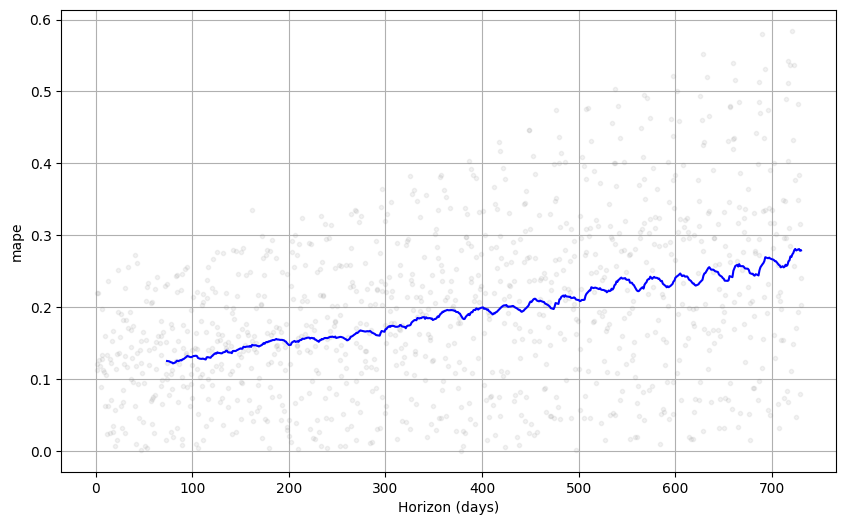

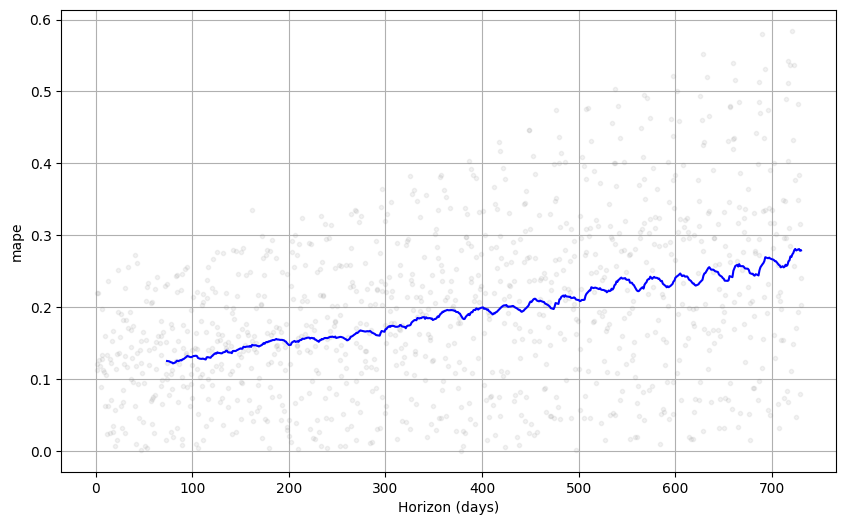

In [75]:
from prophet.plot import plot_cross_validation_metric
plot_cross_validation_metric(df_cv, metric='mape')

In [77]:
# Données Greece uniquement
df_greece = df_prophet_ready[df_prophet_ready['country'] == 'Greece'][['ds', 'y']].copy()

# Entraînement du modèle Prophet
model = Prophet(
    changepoints=['1995-01-01', '2008-01-01', '2013-01-01', '2020-03-01'],
    yearly_seasonality=True,
    changepoint_prior_scale=0.1,
    seasonality_mode='additive',
    holidays=None,
    interval_width=0.95,
    daily_seasonality=False,
    weekly_seasonality=False
) 
model.add_seasonality(name='quarterly', period=91.31, fourier_order=5)
model.fit(df_greece)

# Cross-validation : prédire 2 ans à l'avance, en avançant tous les 6 mois
df_cv = cross_validation(
    model,
    initial='3650 days',
    period='180 days',
    horizon='730 days'
)

# Évaluation des performances
df_perf = performance_metrics(df_cv)
print(df_perf[['horizon', 'rmse', 'mae', 'mape']].head())

# Moyennes globales
print("\nMoyennes sur la validation croisée :")
print(df_perf[['rmse', 'mae', 'mape']].mean())

15:11:02 - cmdstanpy - INFO - Chain [1] start processing
15:11:02 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/45 [00:00<?, ?it/s]15:11:03 - cmdstanpy - INFO - Chain [1] start processing
15:11:03 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 1/45 [00:00<00:11,  3.81it/s]15:11:03 - cmdstanpy - INFO - Chain [1] start processing
15:11:03 - cmdstanpy - INFO - Chain [1] done processing
  4%|▍         | 2/45 [00:00<00:11,  3.65it/s]15:11:03 - cmdstanpy - INFO - Chain [1] start processing
15:11:03 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 3/45 [00:00<00:11,  3.59it/s]15:11:04 - cmdstanpy - INFO - Chain [1] start processing
15:11:04 - cmdstanpy - INFO - Chain [1] done processing
  9%|▉         | 4/45 [00:01<00:11,  3.66it/s]15:11:04 - cmdstanpy - INFO - Chain [1] start processing
15:11:04 - cmdstanpy - INFO - Chain [1] done processing
 11%|█         | 5/45 [00:01<00:10,  3.70it/s]15:11:04 - cmdstanpy - INFO - Chain [1] start processi

  horizon      rmse       mae      mape
0 74 days  2.460789  2.011337  0.124886
1 76 days  2.458231  2.009227  0.124522
2 78 days  2.432333  1.980784  0.123099
3 79 days  2.425984  1.979847  0.122862
4 80 days  2.403356  1.954190  0.121621

Moyennes sur la validation croisée :
rmse    4.173870
mae     3.318569
mape    0.195133
dtype: float64


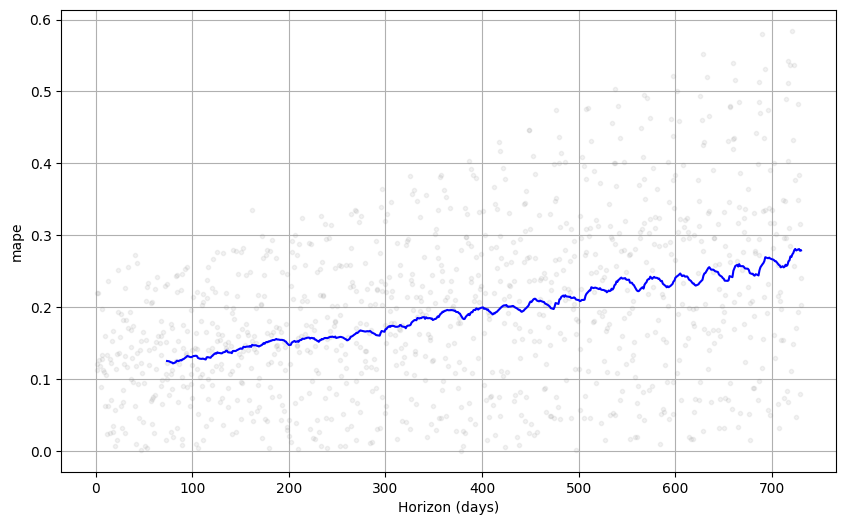

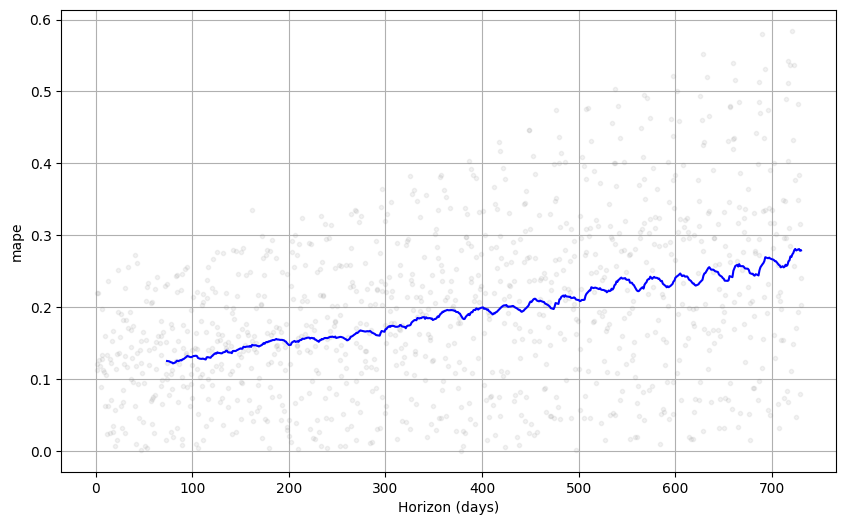

In [78]:
from prophet.plot import plot_cross_validation_metric
plot_cross_validation_metric(df_cv, metric='mape')

Le cross validation teste comment le modèle aurait prédit plusieurs fois par le passé, en ne voyant que l’historique disponible à l’époque.

C’est donc une vérification plus robuste : elle teste la stabilité du modèle dans le temps.

Le MAPE de 19 % reflète une performance moyenne réelle sur plusieurs périodes, pas juste sur 2024–2025.

Flagrant pour UK, prédiction très bonne en temps stable 2024-2025 (facile à prédire taux constant) et puis avec cross validation on voit qu'il prédit très mal avant 2024 (Grosse variation)

Conclusion : Le modèle Prophet n'est pas fait pour la prédiction du taux de chomage, il ne permet de capter seulement la tendance de celui ci pas de saisonalité

In [67]:
# Calcul des résidus d'entraînement
residuals_train_all = []

for country in df_prophet_ready['country'].unique():
    df_country = df_prophet_ready[df_prophet_ready['country'] == country][['ds', 'y']].copy()
    train = df_country[df_country['ds'] < '2024-01-01'].copy()

    model = Prophet(
        changepoints=['1995-01-01', '2008-01-01', '2013-01-01', '2020-03-01'],
        yearly_seasonality=True,
        changepoint_prior_scale=0.2,
        seasonality_mode='additive',
        holidays=None,
        interval_width=0.95,
        daily_seasonality=False,
        weekly_seasonality=False
    )
    model.add_seasonality(name='quarterly', period=91.31, fourier_order=5)
    model.fit(train)

    forecast = model.predict(train[['ds']])
    train_residuals = train[['ds', 'y']].copy()
    train_residuals['yhat'] = forecast['yhat'].values
    train_residuals['residual'] = train_residuals['y'] - train_residuals['yhat']
    train_residuals['country'] = country

    residuals_train_all.append(train_residuals)

# Concaténation des résultats
residuals_df = pd.concat(residuals_train_all).reset_index(drop=True)

14:01:55 - cmdstanpy - INFO - Chain [1] start processing
14:01:55 - cmdstanpy - INFO - Chain [1] done processing
14:01:55 - cmdstanpy - INFO - Chain [1] start processing
14:01:56 - cmdstanpy - INFO - Chain [1] done processing
14:01:56 - cmdstanpy - INFO - Chain [1] start processing
14:01:56 - cmdstanpy - INFO - Chain [1] done processing
14:01:56 - cmdstanpy - INFO - Chain [1] start processing
14:01:56 - cmdstanpy - INFO - Chain [1] done processing
14:01:56 - cmdstanpy - INFO - Chain [1] start processing
14:01:57 - cmdstanpy - INFO - Chain [1] done processing
14:01:57 - cmdstanpy - INFO - Chain [1] start processing
14:01:57 - cmdstanpy - INFO - Chain [1] done processing


In [69]:
residuals_df.head()

,ds,y,yhat,residual,country
0,1991-01-01,9.2,9.566937,-0.366937,France
1,1991-02-01,9.3,9.578924,-0.278924,France
2,1991-03-01,9.3,9.691408,-0.391408,France
3,1991-04-01,9.4,9.731554,-0.331554,France
4,1991-05-01,9.4,9.840291,-0.440291,France


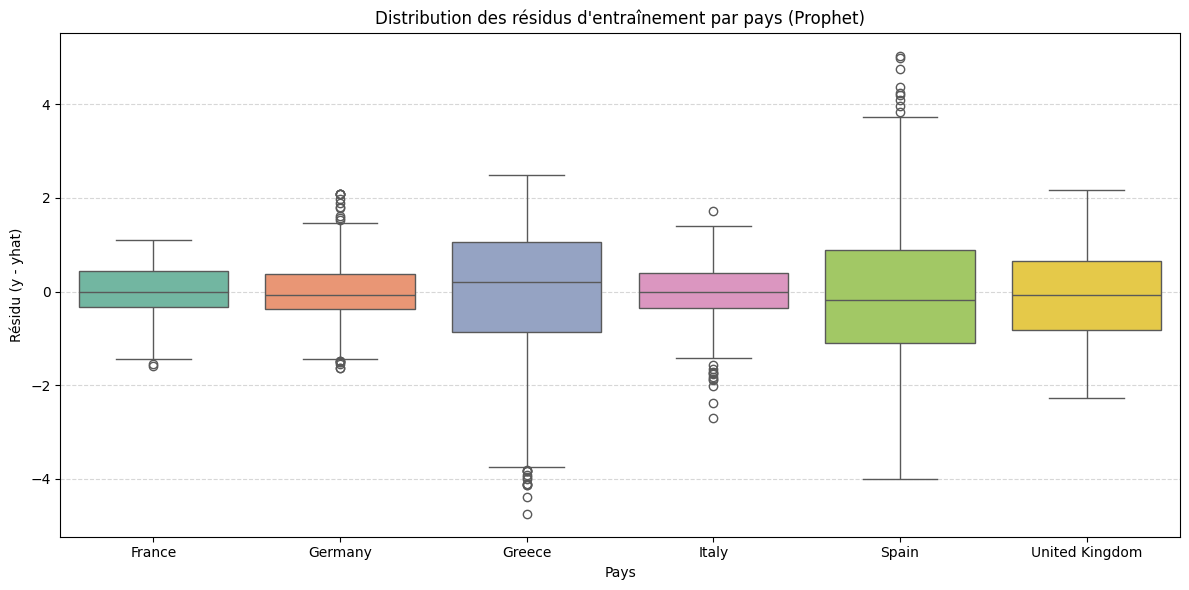

In [70]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='country', y='residual', data=residuals_df, palette='Set2')
plt.title("Distribution des résidus d'entraînement par pays (Prophet)")
plt.xlabel("Pays")
plt.ylabel("Résidu (y - yhat)")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


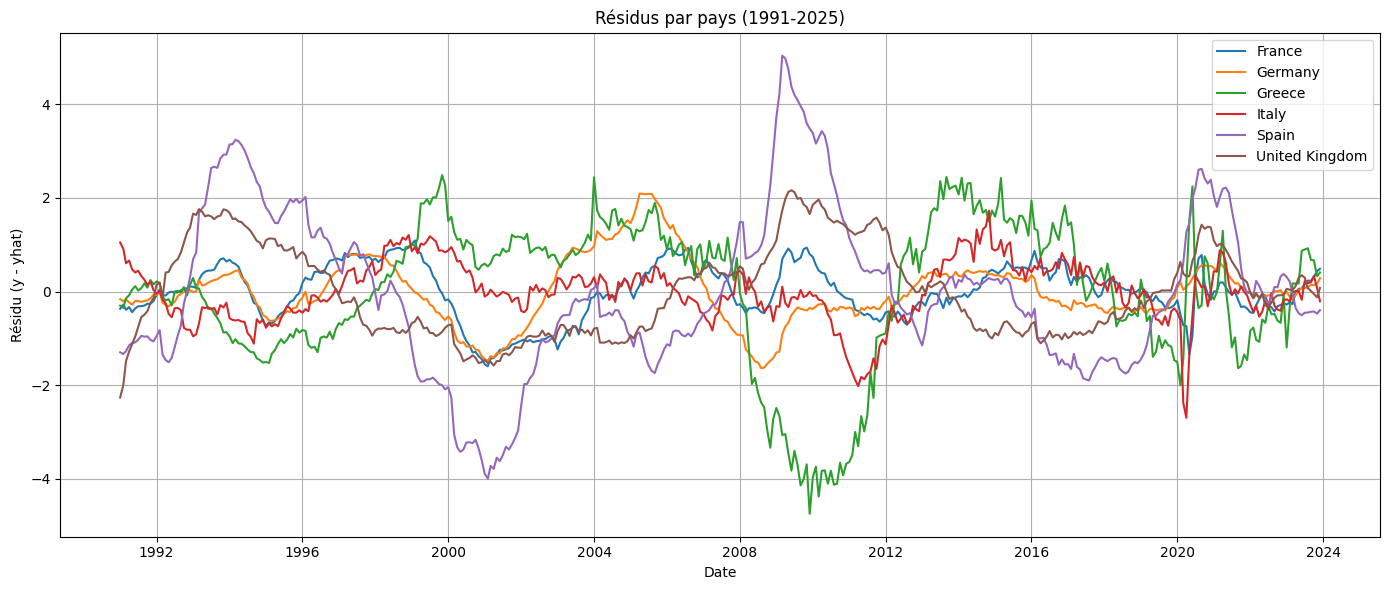

In [73]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=residuals_df, x='ds', y='residual', hue='country')
plt.title('Résidus par pays (1991-2025)')
plt.xlabel('Date')
plt.ylabel('Résidu (y - yhat)')
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()